In [10]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
# Define dataset path
dataset_path = '/kaggle/input/prinom/CoLeaf DATASET'
output_path = '/kaggle/working/augmented_dataset'

In [12]:
# Classes to remove
remove_classes = ['healthy', 'iron-Fe']


In [13]:
# Target number of images per class
target_count = 200

In [14]:
# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [15]:
# Helper function to augment images
def augment_images(class_dir, class_name, target_count):
    images = os.listdir(class_dir)
    num_images = len(images)
    augmented_images = []

    if num_images >= target_count:
        # If there are more than or equal to target_count images, copy them directly
        for img_name in images[:target_count]:
            img_path = os.path.join(class_dir, img_name)
            shutil.copy(img_path, os.path.join(output_path, class_name, img_name))
    else:
        # If there are fewer images, augment them
        while len(augmented_images) < target_count - num_images:
            for img_name in images:
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                i = 0
                for batch in datagen.flow(x, batch_size=1):
                    augmented_img = array_to_img(batch[0], scale=True)
                    augmented_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg"
                    augmented_img_path = os.path.join(output_path, class_name, augmented_img_name)
                    save_img(augmented_img_path, augmented_img)
                    augmented_images.append(augmented_img_path)
                    i += 1
                    if len(augmented_images) >= target_count - num_images:
                        break

        # Copy original images to output directory
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            shutil.copy(img_path, os.path.join(output_path, class_name, img_name))


In [16]:
# Create output directories
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [17]:
# Process each class directory
for class_name in os.listdir(dataset_path):
    if class_name in remove_classes:
        continue
    class_dir = os.path.join(dataset_path, class_name)
    output_class_dir = os.path.join(output_path, class_name)
    if not os.path.exists(output_class_dir):
        os.makedirs(output_class_dir)
    augment_images(class_dir, class_name, target_count)


In [18]:
# Check the count of images in each class
for class_name in os.listdir(output_path):
    class_dir = os.path.join(output_path, class_name)
    print(f"{class_name}: {len(os.listdir(class_dir))} images")

print("Data augmentation and preprocessing completed.")


boron-B: 300 images
manganese-Mn: 282 images
magnesium-Mg: 278 images
nitrogen-N: 263 images
more-deficiencies: 303 images
potasium-K: 295 images
phosphorus-P: 200 images
calcium-Ca: 361 images
Data augmentation and preprocessing completed.


In [19]:
# Image data generation with more augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the data for validation
)


In [20]:
train_data = datagen.flow_from_directory(
    output_path,
    target_size=(224, 224),
    batch_size=32,
    subset='training'
)

validation_data = datagen.flow_from_directory(
    output_path,
    target_size=(224, 224),
    batch_size=32,
    subset='validation'
)


Found 1828 images belonging to 8 classes.
Found 454 images belonging to 8 classes.


In [21]:
# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/58 ━━━━━━━━━━━━━━━━━━━━ 39:54 42s/step - accuracy: 0.0625 - loss: 2.6543

I0000 00:00:1716309678.466960     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716309678.488288     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/58 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2110 - loss: 5.2750 

W0000 00:00:1716309745.986803     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2213 - loss: 5.0198

W0000 00:00:1716309753.720764     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.2226 - loss: 4.9870 - val_accuracy: 0.2291 - val_loss: 2.0195
Epoch 2/50


W0000 00:00:1716309781.561160     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.4813 - loss: 1.5189 - val_accuracy: 0.3018 - val_loss: 1.9130
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5263 - loss: 1.3597 - val_accuracy: 0.3128 - val_loss: 2.0822
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5411 - loss: 1.3586 - val_accuracy: 0.3392 - val_loss: 1.9355
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5771 - loss: 1.2747 - val_accuracy: 0.2863 - val_loss: 1.9610
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6110 - loss: 1.1800 - val_accuracy: 0.3612 - val_loss: 2.0653
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6022 - loss: 1.1531 - val_accuracy: 0.3700 - val_loss: 1.9046
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6173 - loss: 1.1351 - val_accuracy: 0.3502 - val_loss: 1.8916
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6465 - loss: 1.1009 - val_accuracy: 0.3833 - val_loss: 1.8217
Epo

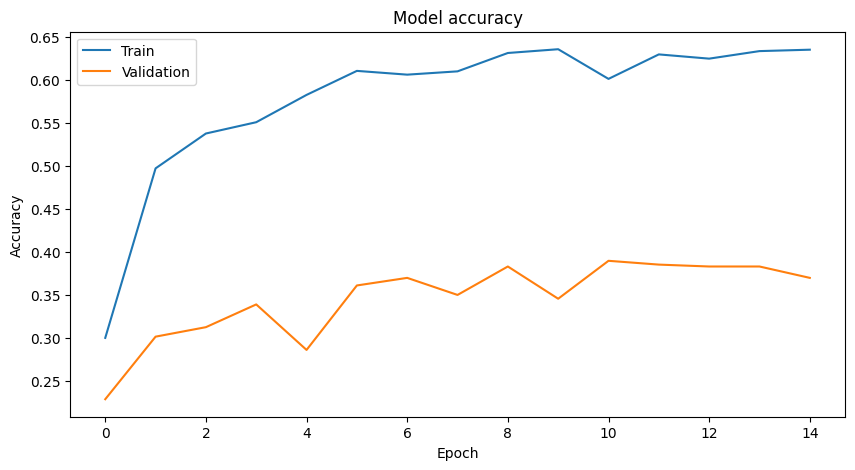

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


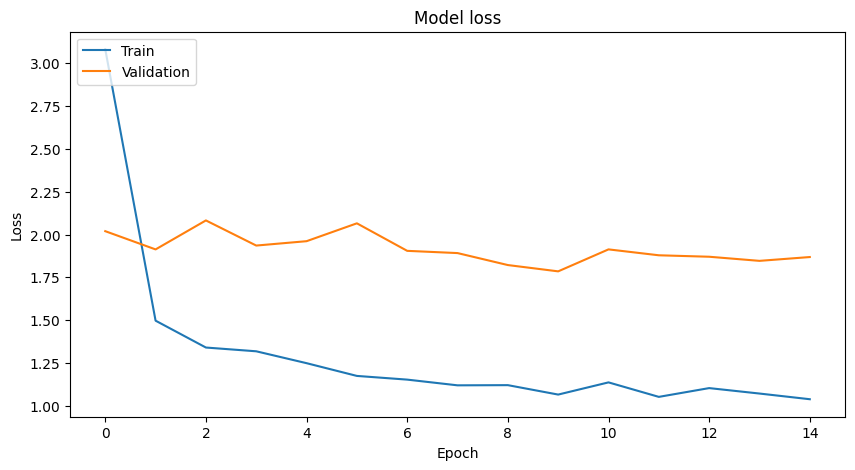

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [25]:
# Function to plot predictions
def plot_predictions(model, dataset, class_labels, num_images=9):
    plt.figure(figsize=(12, 12))
    
    images, labels = next(dataset)  # Get a batch of images and labels from the generator
    predictions = model.predict(images)
    
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        image = images[i]
        true_label = class_labels[np.argmax(labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}, True: {true_label}")
        plt.axis("off")
    
    plt.show()


In [26]:
# Mapping of class indices to class labels
class_labels = {v: k for k, v in train_data.class_indices.items()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


W0000 00:00:1716311119.399041     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


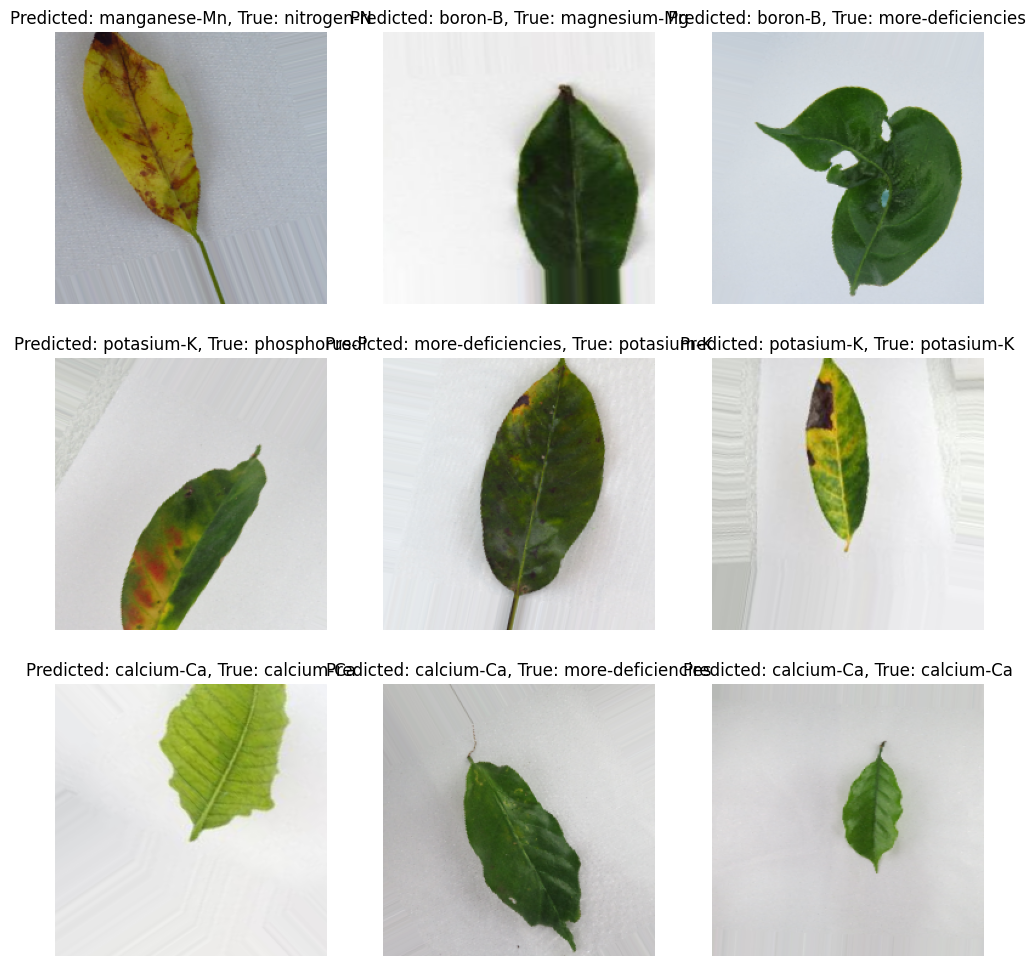

In [27]:
# Plot predictions using the custom CNN model
plot_predictions(model, validation_data, class_labels)